Учебный проект.<br>
Авторы:<br>
Александр Пуголовок,<br>
Юрий Ланбин,<br>
Максун Карабаглы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import statistics
import pandas as pd

from tqdm import tqdm

In [ ]:
torch.cuda.is_available()

False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
classes = ('dog', 'cat' )

In [ ]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))

    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self, idx):
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)

        img = img.transpose((2,0,1))

        t_img = torch.from_numpy(img)

        t_class_id = torch.tensor(class_id)

        return t_img, t_class_id

In [ ]:
!ls drive/MyDrive/dataset_c_d/training_set/dogs/dog.1000.jpg

drive/MyDrive/dataset_c_d/training_set/dogs/dog.1000.jpg


In [ ]:
train_dogs_path = 'drive/MyDrive/dataset_c_d/training_set/dogs'
train_cats_path = 'drive/MyDrive/dataset_c_d/training_set/cats'
test_dogs_path = 'drive/MyDrive/dataset_c_d/test_set/dogs'
test_cats_path = 'drive/MyDrive/dataset_c_d/test_set/cats'

train_ds_catsdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catsdogs = Dataset2class(test_dogs_path, test_cats_path)

In [ ]:
len(train_ds_catsdogs)

8000

In [ ]:
train_ds_catsdogs[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
len(test_ds_catsdogs)

2000

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_ds_catsdogs, shuffle=True,
                    batch_size= batch_size, num_workers=1, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_ds_catsdogs, shuffle=True,
                   batch_size= batch_size, num_workers=1, drop_last=False)

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_ds_catsdogs, shuffle=True,
                    batch_size= batch_size, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_ds_catsdogs, shuffle=False,
                   batch_size= batch_size, drop_last=False)

In [ ]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([16, 3, 64, 64]) torch.Size([16])


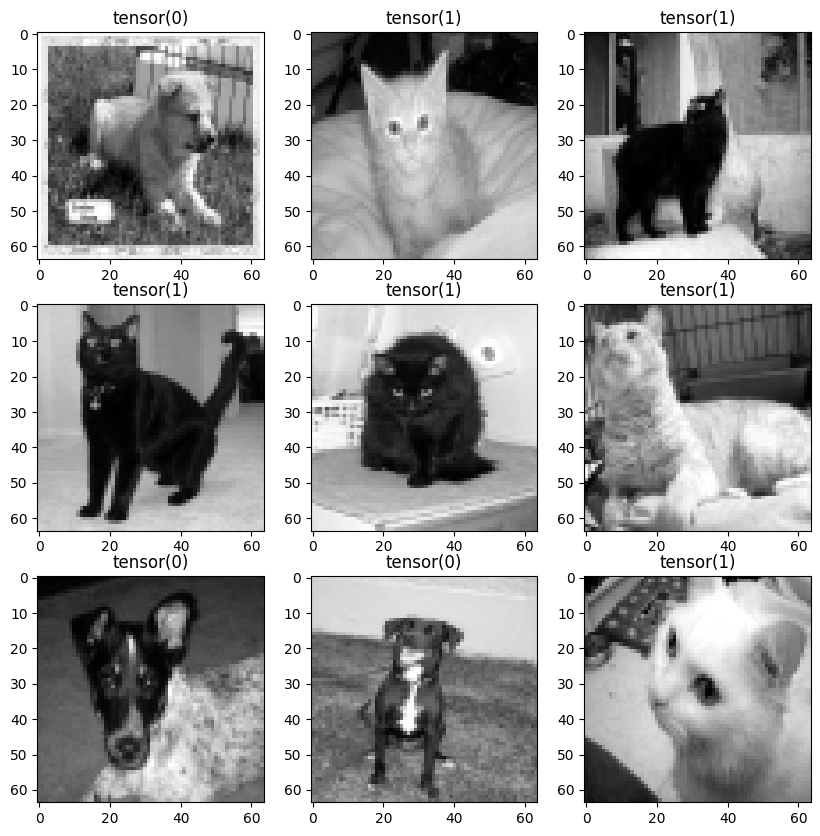

In [ ]:
plt.figure(figsize= ((10,10)))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.title(labels[i])
plt.show()

In [ ]:
# without same chanels
# 32 64 128 256

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)

        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999))

In [ ]:
# without same chanels
# 32 64 128 256

num_epochs = 10
n_total_steps = len(train_loader)
loss_train_arr = [] # значения функции потерь
acc_train_arr = []
acc_test_arr = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt, ' of 10')
    cnt += 1
    loss_train_arr_for_mean = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        #images = images.reshape(-1, 64*64).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Step [{i+1}/{n_total_steps}],  Training Loss: {loss.item():.4f}')
            loss_train_arr_for_mean.append(loss.item())
    mean_loss_arr = statistics.mean(loss_train_arr_for_mean)
    print('Mean Tr Loss in epoch:', round(mean_loss_arr, 4))
    loss_train_arr.append(mean_loss_arr)


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                #images = images.reshape(-1, 64*64).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {round(acc_train, 1)} %')
    acc_train_arr.append(round(acc_train, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {round(acc, 1)} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            #images = images.reshape(-1, 64*64).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {round(acc_test, 1)} %')
    acc_test_arr.append(round(acc_test, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {round(acc, 1)} %')

    print()
    print()
    # print()
print('loss_train_arr:',loss_train_arr)
print('acc_train_arr:', acc_train_arr)
print('acc_test_arr:', acc_test_arr)

Epoch numper  1  of 10
Step [50/500],  Training Loss: 0.6904
Step [100/500],  Training Loss: 0.6734
Step [150/500],  Training Loss: 0.6932
Step [200/500],  Training Loss: 0.6996
Step [250/500],  Training Loss: 0.6890
Step [300/500],  Training Loss: 0.6880
Step [350/500],  Training Loss: 0.6718
Step [400/500],  Training Loss: 0.6959
Step [450/500],  Training Loss: 0.6788
Step [500/500],  Training Loss: 0.6314
Mean Tr Loss in epoch: 0.6811
Accuracy of the network ON TRAIN: 50.7 %
Accuracy ON TRAIN of dog: 0.0 %
Accuracy ON TRAIN of cat: 100.0 %
Accuracy of the network ON TEST: 50.0 %
Accuracy ON TEST of dog: 0.0 %
Accuracy ON TEST of cat: 99.9 %


Epoch numper  2  of 10
Step [50/500],  Training Loss: 0.7096
Step [100/500],  Training Loss: 0.7282
Step [150/500],  Training Loss: 0.6641
Step [200/500],  Training Loss: 0.6299
Step [250/500],  Training Loss: 0.7029
Step [300/500],  Training Loss: 0.7706
Step [350/500],  Training Loss: 0.7000
Step [400/500],  Training Loss: 0.6593
Step [450/50

In [ ]:
# с простой релу и без адаптивпула № 1
# cnn 1

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
# с простой релу и без адаптивпула № 1

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        # self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        # self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        # self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        # self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        # self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        #self.act = nn.LeakyReLU(0.2)
        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        #self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)
        out = self.maxpool(out)

        #out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet().to(device)

In [ ]:
model

ConvNet(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linenear1): Linear(in_features=64, out_features=10, bias=True)
  (linenear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999))

In [ ]:
# с простой релу и без адаптивпула № 1
# cnn 1

num_epochs = 10
n_total_steps = len(train_loader)
loss_train_arr = []
acc_train_arr = []
acc_test_arr = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt)
    cnt += 1
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], \
                   Training Loss: {loss.item():.4f}')
            loss_train_arr.append(loss.item())


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {acc_train} %')
    acc_train_arr.append(acc_train)

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {acc} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {acc_test} %')
    acc_test_arr.append(acc_test)

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {acc} %')

    print()
    print()
    print()

In [ ]:
# magor 256

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)

        self.act = nn.LeakyReLU(0.2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.maxpool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256,20)
        self.linear2 = nn.Linear(20,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999))

In [ ]:
# magor 256

num_epochs = 30
n_total_steps = len(train_loader)
loss_train_arr = [] # значения функции потерь
acc_train_arr = []
acc_test_arr = []
loss_test_arr = []
acc_dog = []
acc_cat = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt, ' of 30')
    cnt += 1
    loss_train_arr_for_mean = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        #images = images.reshape(-1, 64*64).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Step [{i+1}/{n_total_steps}],  Training Loss: {loss.item():.4f}')
            loss_train_arr_for_mean.append(loss.item())
    mean_loss_arr = statistics.mean(loss_train_arr_for_mean)
    print('Mean Tr Loss in epoch:', round(mean_loss_arr, 4))
    loss_train_arr.append(round(mean_loss_arr, 4))


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                #images = images.reshape(-1, 64*64).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {round(acc_train, 4)} %')
    acc_train_arr.append(round(acc_train, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {round(acc, 4)} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    loss_test_arr_in_epoch = []
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            #images = images.reshape(-1, 64*64).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss_test = criterion(outputs, labels)
            loss_test_arr_in_epoch.append(loss_test.item())


            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    mean_loss_test_arr = statistics.mean(loss_test_arr_in_epoch)
    print('Loss on TEST:', round(mean_loss_test_arr, 4))
    loss_test_arr.append(round(mean_loss_test_arr,4))

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {round(acc_test, 4)} %')
    acc_test_arr.append(round(acc_test, 4))

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {round(acc, 4)} %')
        if i == 0:
            acc_dog.append(acc)
        else:
            acc_cat.append(acc)

    print()
    print()
    # print()
print('loss_train_arr:', loss_train_arr)
print('loss_test_arr:', loss_test_arr)
print('acc_train_arr:', acc_train_arr)
print('acc_test_arr:', acc_test_arr)
print('acc_dog:', acc_dog)
print('acc_cat:', acc_cat)

loss_train_arr_series = pd.Series(loss_train_arr)
loss_train_arr_series.to_csv('drive/MyDrive/cnn_256_loss_train_arr.csv')

loss_test_arr_series = pd.Series(loss_test_arr)
loss_test_arr_series.to_csv('drive/MyDrive/cnn_256_loss_test_arr.csv')

acc_train_arr_series = pd.Series(acc_train_arr)
acc_train_arr_series.to_csv('drive/MyDrive/cnn_256_acc_train_arr.csv')

acc_test_arr_series = pd.Series(acc_test_arr)
acc_test_arr_series.to_csv('drive/MyDrive/cnn_256_acc_test_arr.csv')

acc_dog_series = pd.Series(acc_dog)
acc_dog_series.to_csv('drive/MyDrive/cnn_256_acc_dog.csv')

acc_cat_series = pd.Series(acc_cat)
acc_cat_series.to_csv('drive/MyDrive/cnn_256_acc_cat.csv')

Epoch numper  1  of 30
Step [50/500],  Training Loss: 0.6935
Step [100/500],  Training Loss: 0.6950
Step [150/500],  Training Loss: 0.7088
Step [200/500],  Training Loss: 0.6999
Step [250/500],  Training Loss: 0.6889
Step [300/500],  Training Loss: 0.6957
Step [350/500],  Training Loss: 0.6917
Step [400/500],  Training Loss: 0.6807
Step [450/500],  Training Loss: 0.6994
Step [500/500],  Training Loss: 0.7187
Mean Tr Loss in epoch: 0.6972
Accuracy of the network ON TRAIN: 54.15 %
Accuracy ON TRAIN of dog: 82.9871 %
Accuracy ON TRAIN of cat: 24.6714 %
Loss on TEST: 0.6854
Accuracy of the network ON TEST: 55.6 %
Accuracy ON TEST of dog: 84.0 %
Accuracy ON TEST of cat: 27.2 %


Epoch numper  2  of 30
Step [50/500],  Training Loss: 0.6880
Step [100/500],  Training Loss: 0.6882
Step [150/500],  Training Loss: 0.6889
Step [200/500],  Training Loss: 0.6828
Step [250/500],  Training Loss: 0.6708
Step [300/500],  Training Loss: 0.6871
Step [350/500],  Training Loss: 0.6864
Step [400/500],  Train

Text(0.5, 1.0, 'Losses on train and test sets')

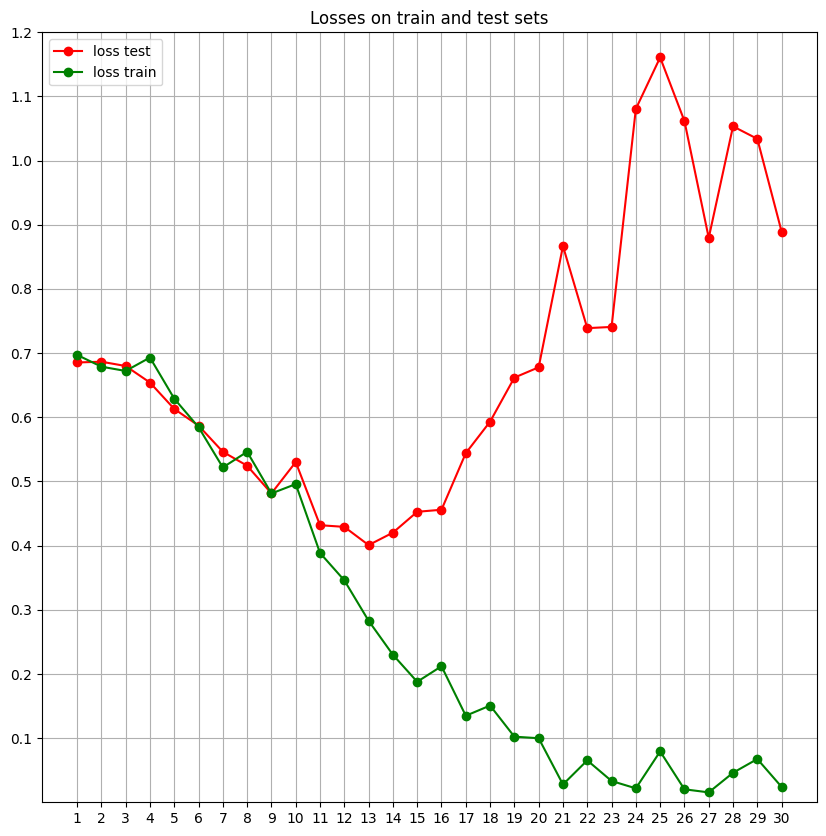

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.plot(x,loss_test_arr, marker = 'o', c = 'r', label = 'loss test')
ax.plot(x,loss_train_arr, marker = 'o', c = 'g',label = 'loss train')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 1.1, 1.2]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(0,1.2)
ax.legend(loc='upper left')
ax.set_title("Losses on train and test sets")

Text(0.5, 1.0, 'Accuracy on train and test sets')

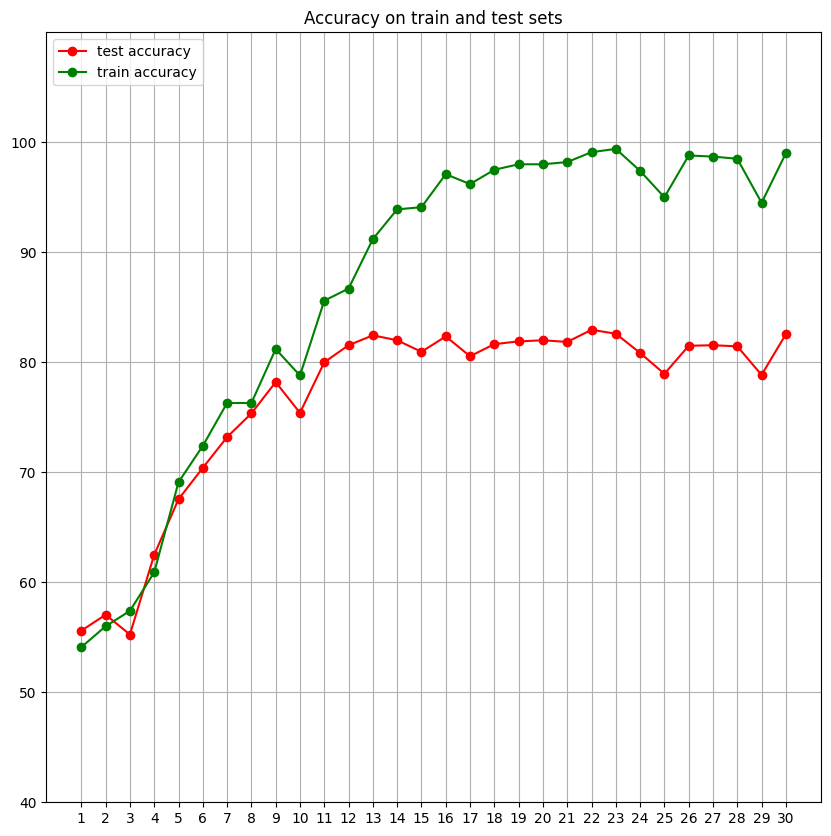

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

ax.plot(x,acc_test_arr, marker = 'o', c = 'r', label = 'test accuracy')
ax.plot(x,acc_train_arr, marker = 'o', c = 'g',label = 'train accuracy')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [i for i in range(40,110,10)]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(40,110.0)
ax.legend(loc='upper left')
ax.set_title("Accuracy on train and test sets")

Text(0.5, 1.0, 'Dog and cat accuracy on test set')

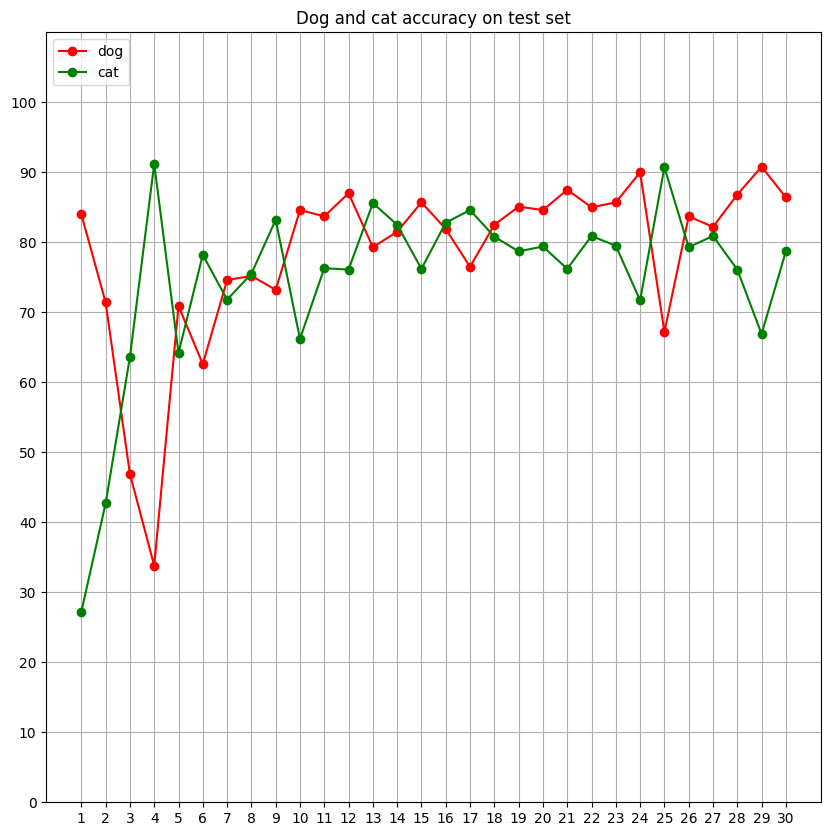

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

ax.plot(x,acc_dog, marker = 'o', c = 'r', label = 'dog')
ax.plot(x,acc_cat, marker = 'o', c = 'g',label = 'cat')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [i for i in range(0,110,10)]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(0,110.0)
ax.legend(loc='upper left')
ax.set_title("Dog and cat accuracy on test set")

In [ ]:
# magor 80.7

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.act = nn.LeakyReLU(0.2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.maxpool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999))

In [ ]:
# magor new

num_epochs = 30
n_total_steps = len(train_loader)
loss_train_arr = [] # значения функции потерь
acc_train_arr = []
acc_test_arr = []
loss_test_arr = []
acc_dog = []
acc_cat = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt, ' of 30')
    cnt += 1
    loss_train_arr_for_mean = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        #images = images.reshape(-1, 64*64).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Step [{i+1}/{n_total_steps}],  Training Loss: {loss.item():.4f}')
            loss_train_arr_for_mean.append(loss.item())
    mean_loss_arr = statistics.mean(loss_train_arr_for_mean)
    print('Mean Tr Loss in epoch:', round(mean_loss_arr, 4))
    loss_train_arr.append(mean_loss_arr)


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                #images = images.reshape(-1, 64*64).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {round(acc_train, 4)} %')
    acc_train_arr.append(round(acc_train, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {round(acc, 4)} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    loss_test_arr_in_epoch = []
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            #images = images.reshape(-1, 64*64).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss_test = criterion(outputs, labels)
            loss_test_arr_in_epoch.append(loss_test.item())


            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    mean_loss_test_arr = statistics.mean(loss_test_arr_in_epoch)
    print('Loss on TEST:', round(mean_loss_test_arr, 4))
    loss_test_arr.append(round(mean_loss_test_arr,4))

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {round(acc_test, 4)} %')
    acc_test_arr.append(round(acc_test, 4))

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {round(acc, 4)} %')
        if i == 0:
            acc_dog.append(acc)
        else:
            acc_cat.append(acc)

    print()
    print()
    # print()
print('loss_train_arr:', loss_train_arr)
print('loss_test_arr:', loss_test_arr)
print('acc_train_arr:', acc_train_arr)
print('acc_test_arr:', acc_test_arr)
print('acc_dog:', acc_dog)
print('acc_cat:', acc_cat)

loss_train_arr_series = pd.Series(loss_train_arr)
loss_train_arr_series.to_csv('drive/MyDrive/cnn_81_loss_train_arr.csv')

loss_test_arr_series = pd.Series(loss_test_arr)
loss_test_arr_series.to_csv('drive/MyDrive/cnn_81_loss_test_arr.csv')

acc_train_arr_series = pd.Series(acc_train_arr)
acc_train_arr_series.to_csv('drive/MyDrive/cnn_81_acc_train_arr.csv')

acc_test_arr_series = pd.Series(acc_test_arr)
acc_test_arr_series.to_csv('drive/MyDrive/cnn_81_acc_test_arr.csv')

acc_dog_series = pd.Series(acc_dog)
acc_dog_series.to_csv('drive/MyDrive/cnn_81_acc_dog.csv')

acc_cat_series = pd.Series(acc_cat)
acc_cat_series.to_csv('drive/MyDrive/cnn_81_acc_cat.csv')

Epoch numper  1  of 30
Step [50/500],  Training Loss: 0.6978
Step [100/500],  Training Loss: 0.6525
Step [150/500],  Training Loss: 0.7281
Step [200/500],  Training Loss: 0.6950
Step [250/500],  Training Loss: 0.7092
Step [300/500],  Training Loss: 0.6932
Step [350/500],  Training Loss: 0.6861
Step [400/500],  Training Loss: 0.6679
Step [450/500],  Training Loss: 0.6834
Step [500/500],  Training Loss: 0.7169
Mean Tr Loss in epoch: 0.693
Accuracy of the network ON TRAIN: 50.7 %
Accuracy ON TRAIN of dog: 0.1013 %
Accuracy ON TRAIN of cat: 100.0 %
Loss on TEST: 0.6934
Accuracy of the network ON TEST: 49.95 %
Accuracy ON TEST of dog: 0.0 %
Accuracy ON TEST of cat: 99.9 %


Epoch numper  2  of 30
Step [50/500],  Training Loss: 0.7099
Step [100/500],  Training Loss: 0.7122
Step [150/500],  Training Loss: 0.7015
Step [200/500],  Training Loss: 0.4554
Step [250/500],  Training Loss: 0.6489
Step [300/500],  Training Loss: 0.6880
Step [350/500],  Training Loss: 0.6126
Step [400/500],  Training L

In [ ]:
loss_train_arr

Text(0.5, 1.0, 'Losses on train and test sets')

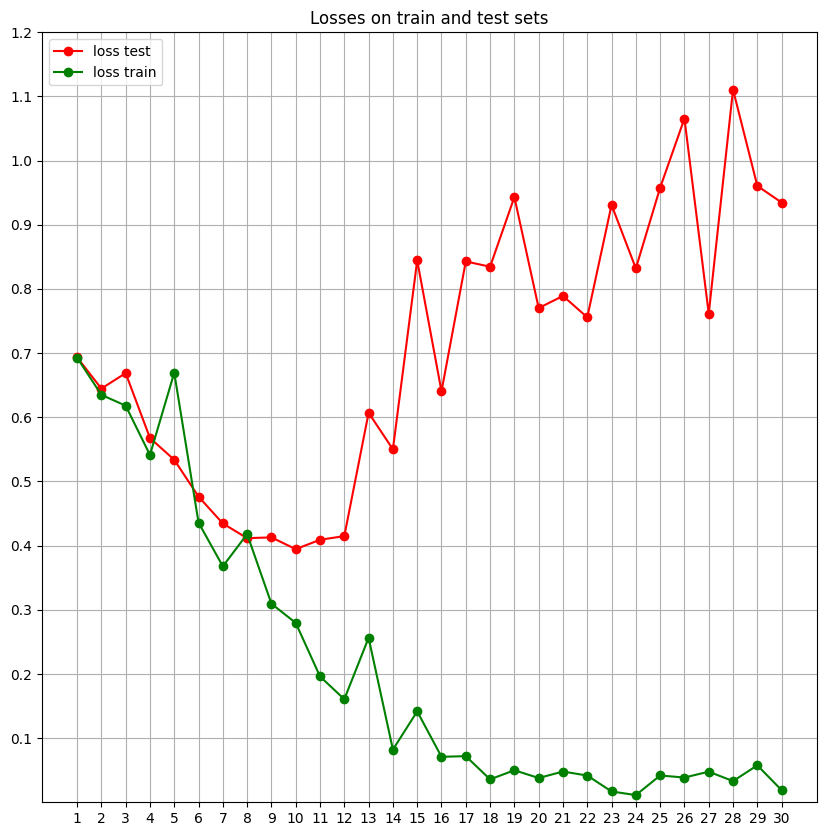

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.plot(x,loss_test_arr, marker = 'o', c = 'r', label = 'loss test')
ax.plot(x,loss_train_arr, marker = 'o', c = 'g',label = 'loss train')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 1.1, 1.2]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(0,1.2)
ax.legend(loc='upper left')
ax.set_title("Losses on train and test sets")

In [ ]:
len(acc_train_arr)

30

Text(0.5, 1.0, 'Accuracy on train and test sets')

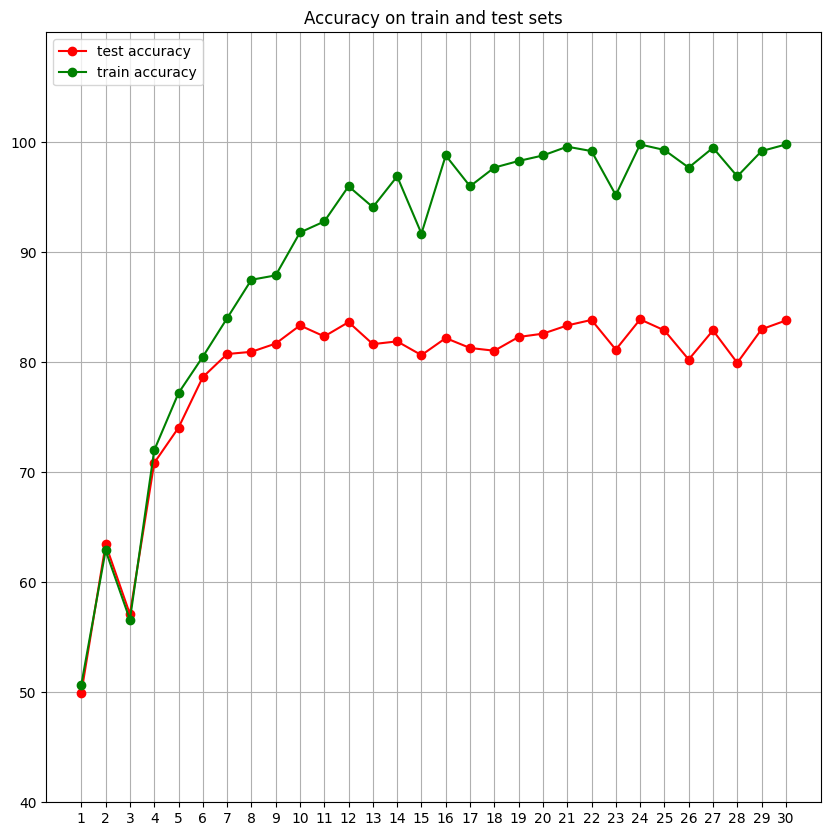

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

ax.plot(x,acc_test_arr, marker = 'o', c = 'r', label = 'test accuracy')
ax.plot(x,acc_train_arr, marker = 'o', c = 'g',label = 'train accuracy')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [i for i in range(40,110,10)]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(40,110.0)
ax.legend(loc='upper left')
ax.set_title("Accuracy on train and test sets")

Text(0.5, 1.0, 'Dog and cat accuracy on test set')

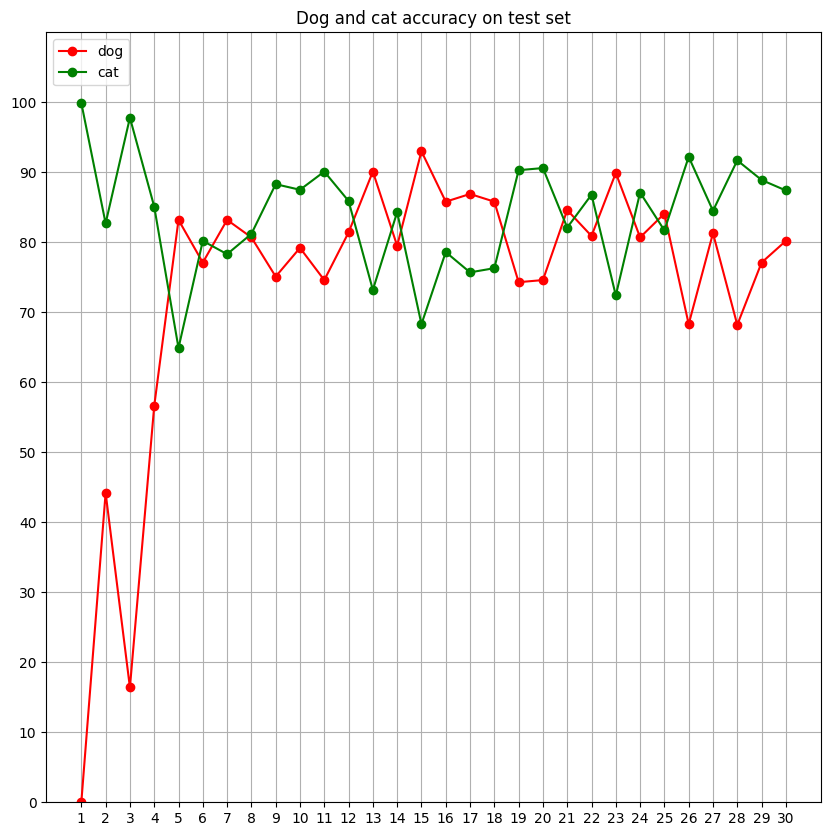

In [ ]:
x = [i for i in range(1,31)]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

ax.plot(x,acc_dog, marker = 'o', c = 'r', label = 'dog')
ax.plot(x,acc_cat, marker = 'o', c = 'g',label = 'cat')

grid_points = [i for i in range(1,31)]
#grid_points = [1., 2., 3.,4.,5.,6.,7.,8.,9., 10.]
grid_points_y = [i for i in range(0,110,10)]
ax.xaxis.set_ticks(grid_points)
ax.yaxis.set_ticks(grid_points_y)
ax.grid(True)
ax.set_ylim(0,110.0)
ax.legend(loc='upper left')
ax.set_title("Dog and cat accuracy on test set")

In [ ]:
# this is magor 80.7
# № 3
# начальное

num_epochs = 10
n_total_steps = len(train_loader)
loss_train_arr = []
acc_train_arr = []
acc_test_arr = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt)
    cnt += 1
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], \
                   Training Loss: {loss.item():.4f}')
            loss_train_arr.append(loss.item())


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {acc_train} %')
    acc_train_arr.append(acc_train)

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {acc} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {acc_test} %')
    acc_test_arr.append(acc_test)

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {acc} %')

    print()
    print()
    print()

Epoch numper  1
Epoch [1/10], Step [50/500], Training Loss: 0.7101
Epoch [1/10], Step [100/500], Training Loss: 0.6951
Epoch [1/10], Step [150/500], Training Loss: 0.6718
Epoch [1/10], Step [200/500], Training Loss: 0.7058
Epoch [1/10], Step [250/500], Training Loss: 0.6852
Epoch [1/10], Step [300/500], Training Loss: 0.6963
Epoch [1/10], Step [350/500], Training Loss: 0.6811
Epoch [1/10], Step [400/500], Training Loss: 0.6916
Epoch [1/10], Step [450/500], Training Loss: 0.6831
Epoch [1/10], Step [500/500], Training Loss: 0.5970
Accuracy of the network ON TRAIN: 52.25 %
Accuracy ON TRAIN of dog: 12.293388429752065 %
Accuracy ON TRAIN of cat: 89.72868217054264 %
Accuracy of the network ON TEST: 51.3 %
Accuracy ON TEST of dog: 12.3 %
Accuracy ON TEST of cat: 90.3 %



Epoch numper  2
Epoch [2/10], Step [50/500], Training Loss: 0.6750
Epoch [2/10], Step [100/500], Training Loss: 0.6925
Epoch [2/10], Step [150/500], Training Loss: 0.6865
Epoch [2/10], Step [200/500], Training Loss: 0.6741


In [ ]:
# without double 32 and 64
# cnn 3 layers

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999))

In [ ]:
# without double 32 and 64

num_epochs = 10
n_total_steps = len(train_loader)
loss_train_arr = [] # значения функции потерь
acc_train_arr = []
acc_test_arr = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt, ' of 10')
    cnt += 1
    loss_train_arr_for_mean = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        #images = images.reshape(-1, 64*64).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Step [{i+1}/{n_total_steps}],  Training Loss: {loss.item():.4f}')
            loss_train_arr_for_mean.append(loss.item())
    mean_loss_arr = statistics.mean(loss_train_arr_for_mean)
    print('Mean Tr Loss in epoch:', round(mean_loss_arr, 4))
    loss_train_arr.append(round(mean_loss_arr,4))


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                #images = images.reshape(-1, 64*64).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {round(acc_train, 1)} %')
    acc_train_arr.append(round(acc_train, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {round(acc, 1)} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            #images = images.reshape(-1, 64*64).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {round(acc_test, 1)} %')
    acc_test_arr.append(round(acc_test, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {round(acc, 1)} %')

    print()
    print()
    # print()
print('loss_train_arr:',loss_train_arr)
print('acc_train_arr:', acc_train_arr)
print('acc_test_arr:', acc_test_arr)

Epoch numper  1  of 10
Step [50/500],  Training Loss: 0.7037
Step [100/500],  Training Loss: 0.7010
Step [150/500],  Training Loss: 0.6832
Step [200/500],  Training Loss: 0.6891
Step [250/500],  Training Loss: 0.7664
Step [300/500],  Training Loss: 0.6179
Step [350/500],  Training Loss: 0.6687
Step [400/500],  Training Loss: 0.5737
Step [450/500],  Training Loss: 0.6556
Step [500/500],  Training Loss: 0.7098
Mean Tr Loss in epoch: 0.6769
Accuracy of the network ON TRAIN: 59.4 %
Accuracy ON TRAIN of dog: 36.6 %
Accuracy ON TRAIN of cat: 81.9 %
Accuracy of the network ON TEST: 60.3 %
Accuracy ON TEST of dog: 41.5 %
Accuracy ON TEST of cat: 79.1 %


Epoch numper  2  of 10
Step [50/500],  Training Loss: 0.6351
Step [100/500],  Training Loss: 0.6505
Step [150/500],  Training Loss: 0.6611
Step [200/500],  Training Loss: 0.5852
Step [250/500],  Training Loss: 0.6932
Step [300/500],  Training Loss: 0.7232
Step [350/500],  Training Loss: 0.9693
Step [400/500],  Training Loss: 0.9155
Step [450/5

# **vgg16**

In [ ]:
# vgg

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        #self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv0 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv0 = nn.Conv2d(3, 64, 3, stride=1, padding=1)

        self.conv1_1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        #self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        # self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        # self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        # self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        # self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        # self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        self.act = nn.LeakyReLU(0.2)
        #self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,10)
        self.linear2 = nn.Linear(10,2)

    def forward(self,x):

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        # out = self.conv1(out)
        # out = self.act(out)
        # out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        # out = self.conv4(out)
        # out = self.act(out)
        # out = self.maxpool(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [ ]:
class VGG(nn.Module):
    """
    Standard PyTorch implementation of VGG. Pretrained imagenet model is used.
    """
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            #nn.Flatten()
        )

        self.classifier = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(8192, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 2)
            #nn.ReLU(),
            #nn.Dropout(),
            #nn.Linear(4096, 2)
        )

        # We need these for MaxUnpool operation
        #self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        #self.feature_maps = OrderedDict()
        #self.pool_locs = OrderedDict()

    def forward(self, x):
        for layer in self.features:
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
            else:
                x = layer(x)

        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
model = VGG().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [ ]:
# vgg

num_epochs = 15
n_total_steps = len(train_loader)
loss_train_arr = [] # значения функции потерь
acc_train_arr = []
acc_test_arr = []

cnt = 1
for epoch in range(num_epochs):
    print('Epoch numper ', cnt, ' of 10')
    cnt += 1
    loss_train_arr_for_mean = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        #images = images.reshape(-1, 64*64).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print (f'Step [{i+1}/{n_total_steps}],  Training Loss: {loss.item():.4f}')
            loss_train_arr_for_mean.append(loss.item())
    mean_loss_arr = statistics.mean(loss_train_arr_for_mean)
    print('Mean Tr Loss in epoch:', round(mean_loss_arr, 4))
    loss_train_arr.append(round(mean_loss_arr,4))


    n_correct_train = 0
    n_samples_train = 0
    n_class_correct_train = [0 for i in range(2)]
    n_class_samples_train = [0 for i in range(2)]
    for k, (images, labels) in enumerate(train_loader):
        if k % 4 == 0:
            model.eval()
            with torch.no_grad():
                #images = images.reshape(-1, 64*64).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples_train += labels.size(0)
                n_correct_train += (predicted == labels).sum().item()

                for i in range(batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if (label == pred):
                        n_class_correct_train[label] += 1
                    n_class_samples_train[label] += 1

    acc_train = 100.0 * n_correct_train / n_samples_train
    print(f'Accuracy of the network ON TRAIN: {round(acc_train, 1)} %')
    acc_train_arr.append(round(acc_train, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct_train[i] / n_class_samples_train[i]
        print(f'Accuracy ON TRAIN of {classes[i]}: {round(acc, 1)} %')


    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        model.eval()
        with torch.no_grad():
            #images = images.reshape(-1, 64*64).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc_test = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network ON TEST: {round(acc_test, 1)} %')
    acc_test_arr.append(round(acc_test, 1))

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy ON TEST of {classes[i]}: {round(acc, 1)} %')

    print()
    print()
    # print()
print('loss_train_arr:',loss_train_arr)
print('acc_train_arr:', acc_train_arr)
print('acc_test_arr:', acc_test_arr)

Epoch numper  1  of 10
Step [50/500],  Training Loss: 0.6928
Step [100/500],  Training Loss: 0.6929
Step [150/500],  Training Loss: 0.6941
Step [200/500],  Training Loss: 0.6931
Step [250/500],  Training Loss: 0.6922
Step [300/500],  Training Loss: 0.6934
Step [350/500],  Training Loss: 0.6920
Step [400/500],  Training Loss: 0.6933
Step [450/500],  Training Loss: 0.6935
Step [500/500],  Training Loss: 0.6917
Mean Tr Loss in epoch: 0.6929
Accuracy of the network ON TRAIN: 50.4 %
Accuracy ON TRAIN of dog: 0.0 %
Accuracy ON TRAIN of cat: 100.0 %
Accuracy of the network ON TEST: 50.0 %
Accuracy ON TEST of dog: 0.0 %
Accuracy ON TEST of cat: 100.0 %


Epoch numper  2  of 10
Step [50/500],  Training Loss: 0.6925
Step [100/500],  Training Loss: 0.6929
Step [150/500],  Training Loss: 0.6927
Step [200/500],  Training Loss: 0.6930
Step [250/500],  Training Loss: 0.6934
Step [300/500],  Training Loss: 0.6928
Step [350/500],  Training Loss: 0.6924
Step [400/500],  Training Loss: 0.6934
Step [450/5

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 5
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/5], Step [20/500], Loss: 0.6842
Epoch [1/5], Step [40/500], Loss: 0.8043
Epoch [1/5], Step [60/500], Loss: 0.6556
Epoch [1/5], Step [80/500], Loss: 0.6846
Epoch [1/5], Step [100/500], Loss: 0.7001
Epoch [1/5], Step [120/500], Loss: 0.6850
Epoch [1/5], Step [140/500], Loss: 0.6831
Epoch [1/5], Step [160/500], Loss: 0.6971
Epoch [1/5], Step [180/500], Loss: 0.6863
Epoch [1/5], Step [200/500], Loss: 0.6793
Epoch [1/5], Step [220/500], Loss: 0.6813
Epoch [1/5], Step [240/500], Loss: 0.6686
Epoch [1/5], Step [260/500], Loss: 0.8820
Epoch [1/5], Step [280/500], Loss: 0.6875
Epoch [1/5], Step [300/500], Loss: 0.6693
Epoch [1/5], Step [320/500], Loss: 0.6628
Epoch [1/5], Step [340/500], Loss: 0.7370
Epoch [1/5], Step [360/500], Loss: 0.6586
Epoch [1/5], Step [380/500], Loss: 0.6753
Epoch [1/5], Step [400/500], Loss: 0.6311
Epoch [1/5], Step [420/500], Loss: 0.6790
Epoch [1/5], Step [440/500], Loss: 0.6446
Epoch [1/5], Step [460/500], Loss: 0.6653
Epoch [1/5], Step [480/500], Loss: 0.7

In [ ]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [ ]:
epochs = 3

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']

        optimizer.zero_grad()

        label = F.one_hot(label, 2).float()
        pred = model(img)

        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f} \taccuracy: {acc_current:.3f}')
    print(loss_val / len(train_loader))
    print(acc_val / len(train_loader))

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-11-335fe52d9cfa>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 500/500 [16:36<00:00,  1.99s/it]


0.6940625824928284
0.511375


100%|██████████| 500/500 [01:23<00:00,  5.98it/s]


0.6807963413000107
0.566375


100%|██████████| 500/500 [01:26<00:00,  5.78it/s]

0.6187943825721741
0.6595
